In [1]:
#!/usr/bin/env python3
import numpy as np
import glob

data_directory = "./vis_project_data/"

# Default weights; used if not set
default_weights = np.array([-1, 0, 1, 2, 2, 3, 5])

# Types of sessions/files:
session_types = ["cog", "so"]
whatdoors = ["indoor", "outdoor"]
whichs = ["base", "inter"]

# Combine to single itteratable list
combined_scenarios = [
    (ses_type, whatdoor, which)
    for ses_type in session_types
    for whatdoor in whatdoors
    for which in whichs
]


In [2]:
def combined_score(filename, weights):
    """Calculates the 'score' for a single session/file.
    Assumes total session duration is 360s, otherwise returns 'nan'.
    This could be modified simply to also return other details of the session."""
    with open(filename, "r") as file:
        score = 0.0
        total_duration = 0.0
        t_end_prev = 0.0
        for count, line in enumerate(file.readlines()):
            # print(count, line)
            data = line.split(",", 4)
            if count == 0:
                continue
            if line[0] == "*":
                break

            t_catagory = int(data[0])
            t_beg = int(data[1])
            t_end = int(data[2])

            if t_beg != t_end_prev:
                print("Error, missing time stamp?")
            t_end_prev = t_end

            assert t_end >= t_beg
            if count == 1:
                assert t_beg == 0

            duration = float(t_end - t_beg)
            total_duration += duration
            score += weights[t_catagory - 1] * duration
        return score / total_duration
        return score if np.abs(total_duration - 1.0) < 1.0e-5 else np.nan

################################################################################

In [3]:
def print_scores(
    ca, peer, cognitive_weights=default_weights, social_weights=default_weights
):
    """Calculates the scores for given ca/peer pair.
    It simply prints the result to screen - to be useful, you will want
    to actually store this data (e.g., return a struct or array etc.).
    """
    trained = "Trained" if "u" <= peer[0] <= "z" else "Untrained"
    print(ca, peer, f"({trained})")
    for ses_type, whatdoor, which in combined_scenarios:

        weights = cognitive_weights if ses_type == "cog" else social_weights

        # glob creates the list of filenames that match the given pattern
        # '*' is a wildcard
        files = glob.glob(
            data_directory + f"{ses_type}-*-{which}-*-{ca}-{peer}-{whatdoor}.dtx"
        )

        if len(files) == 0:
            continue

        scores = []
        for file in files:
            tmp_score = combined_score(file, weights)
            if not np.isnan(tmp_score):
                scores.append(tmp_score)
        scores = np.array(scores)

        mean = scores.mean()
        sdev = scores.std(ddof=1)  # "corrected" sdev
        sem = sdev / np.sqrt(len(scores))
        # Equiv. to:
        # sdev = scores.std()
        # sem = sdev / np.sqrt(len(scores) - 1)

        # len(scores) is the total number of kept (complete) sessions [for this ca/peer]
        # len(files) is the total number of sessions (files) in data directory
        print(
            f"{ses_type:3} {whatdoor:7} {which:5}: {mean:6.3f} +/- {sem:.3f}  [{len(scores)}/{len(files)}]"
        )


################################################################################

In [4]:
def unique_pairs():
    """Returns list of unique ca/peer pairs"""
    all_files = glob.glob(data_directory + "/*.dtx")
    list = []
    for file in all_files:
        t = file.split("-")
        list.append([t[4], t[5]])

    return np.unique(list, axis=0)
    
################################################################################

In [5]:
if __name__ == "__main__":

    # Example usage:

    ca_peer_list = unique_pairs()
    print(ca_peer_list)

    print()

    # From the thesis:
    soc_weights = np.array([-1, 0, 1, 2, 2, 3, 5])

    # Match table 5.1 of thesis
    # cog_weights = np.array([-1, 0, 1, 2, 2, 3, 5])

    # Match matlab example:
    cog_weights = np.array([0, -1, 1, 2, 2, 3, 5])

    # Example:
    ca = "albert"
    peer = "lydia"
    print_scores("albert", "lydia", cog_weights, soc_weights)

    # Or, for all pairs:
    for ca, peer in ca_peer_list:
        print()
        print_scores(ca, peer, cog_weights, soc_weights)

[['albert' 'lydia']
 ['albert' 'ulrich']
 ['barry' 'mario']
 ['barry' 'viola']
 ['chris' 'nellie']
 ['chris' 'wendy']
 ['dana' 'oscar']
 ['dana' 'xavier']
 ['ellie' 'peter']
 ['ellie' 'yoshi']
 ['ellie' 'zara']]

albert lydia (Untrained)
cog indoor  base :  0.033 +/- 0.027  [4/4]
cog indoor  inter:  0.168 +/- 0.084  [13/13]
cog outdoor base :  0.245 +/- 0.110  [4/4]
cog outdoor inter:  0.347 +/- 0.101  [10/10]
so  indoor  base :  0.097 +/- 0.043  [4/4]
so  indoor  inter:  0.129 +/- 0.034  [13/13]
so  outdoor base :  0.101 +/- 0.089  [4/4]
so  outdoor inter:  0.055 +/- 0.016  [10/10]

albert lydia (Untrained)
cog indoor  base :  0.033 +/- 0.027  [4/4]
cog indoor  inter:  0.168 +/- 0.084  [13/13]
cog outdoor base :  0.245 +/- 0.110  [4/4]
cog outdoor inter:  0.347 +/- 0.101  [10/10]
so  indoor  base :  0.097 +/- 0.043  [4/4]
so  indoor  inter:  0.129 +/- 0.034  [13/13]
so  outdoor base :  0.101 +/- 0.089  [4/4]
so  outdoor inter:  0.055 +/- 0.016  [10/10]

albert ulrich (Trained)
cog ind

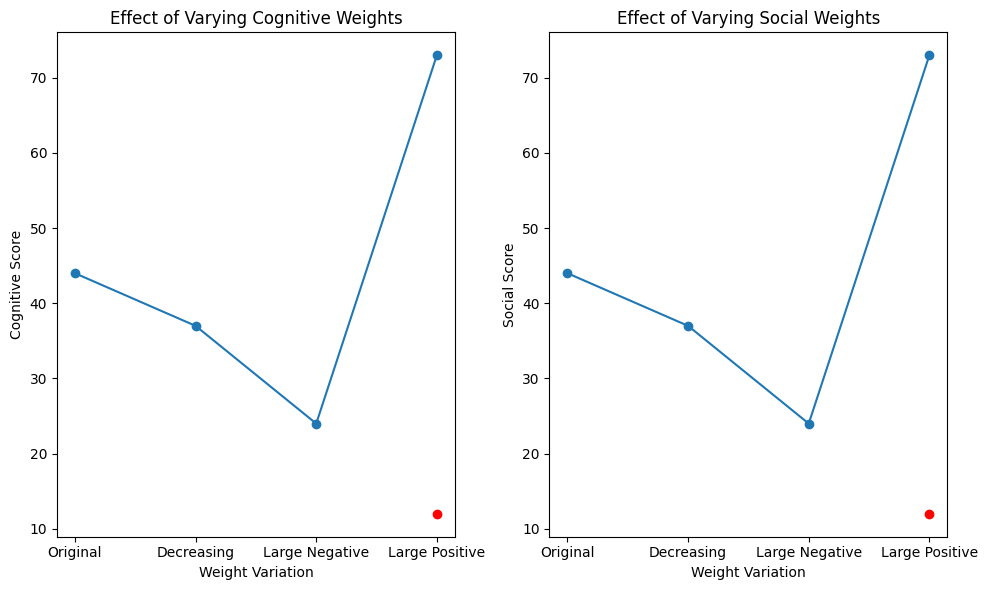

Conclusions:
--------------------------------------------------
1. Original scores: Cognitive Score = 12 , Social Score = 12
1. Variation 1: Cognitive Score increased to 44, Social Score increased to 44
2. Variation 2: Cognitive Score increased to 37, Social Score increased to 37
3. Variation 3: Cognitive Score increased to 24, Social Score increased to 24
4. Variation 4: Cognitive Score increased to 73, Social Score increased to 73


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Original weights
soc_weights = np.array([-1, 0, 1, 2, 2, 3, 5])
cog_weights = np.array([-1, 0, 1, 2, 2, 3, 5])

# Varying weights
varied_weights = [
    np.array([-1, 0, 1, 2, 2, 3, 5]),   # Original
    np.array([-2, -1, 0, 1, 2, 3, 4]),  # Decreasing
    np.array([-5, -3, -2, -1, 1, 2, 3]), # Large negative
    np.array([1, 2, 3, 4, 5, 6, 7]),     # Large positive
]

# Function to calculate scores
def calculate_scores(weights):
    scores = []
    for session_type in ["cog", "so"]:
        # Combine weights based on session type
        weights_to_use = cog_weights if session_type == "cog" else soc_weights
        # Calculate score using combined weights
        score = np.sum(weights_to_use * weights)
        scores.append(score)
    return scores

# Calculate original scores
original_scores = calculate_scores(np.array([1, 1, 1, 1, 1, 1, 1]))

# Calculate scores for varied weights
varied_scores = [calculate_scores(weights) for weights in varied_weights]

# Plotting
x = np.arange(len(varied_weights))

plt.figure(figsize=(10, 6))

# Plot cognitive scores
plt.subplot(1, 2, 1)
plt.plot(x, [score[0] for score in varied_scores], marker='o')
plt.plot(len(x) - 1, original_scores[0], 'ro')  # Highlight original score
plt.xticks(ticks=x, labels=['Original', 'Decreasing', 'Large Negative', 'Large Positive'])
plt.title('Effect of Varying Cognitive Weights')
plt.xlabel('Weight Variation')
plt.ylabel('Cognitive Score')

# Plot social scores
plt.subplot(1, 2, 2)
plt.plot(x, [score[1] for score in varied_scores], marker='o')
plt.plot(len(x) - 1, original_scores[1], 'ro')  # Highlight original score
plt.xticks(ticks=x, labels=['Original', 'Decreasing', 'Large Negative', 'Large Positive'])
plt.title('Effect of Varying Social Weights')
plt.xlabel('Weight Variation')
plt.ylabel('Social Score')

plt.tight_layout()
plt.show()

# Conclusions
print("Conclusions:")
print("-"*50)
print("1. Original scores: Cognitive Score =", original_scores[0], ", Social Score =", original_scores[1])

for i, weights in enumerate(varied_weights):
    cog_score, soc_score = varied_scores[i]
    if cog_score > original_scores[0]:
        cog_change = "increased"
    elif cog_score < original_scores[0]:
        cog_change = "decreased"
    else:
        cog_change = "remained unchanged"

    if soc_score > original_scores[1]:
        soc_change = "increased"
    elif soc_score < original_scores[1]:
        soc_change = "decreased"
    else:
        soc_change = "remained unchanged"

    print(f"{i+1}. Variation {i+1}: Cognitive Score {cog_change} to {cog_score}, Social Score {soc_change} to {soc_score}")

